In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_error
import umap.umap_ as umap
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import minmax_scale
#import sklearn as sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [5]:
# load data
URL = "hotel_bookings_ohe.csv"
df_ = pd.read_csv(URL)
# df_.head()
# df_.shape

## Train vs Test Splitting

In [6]:
# load the data into a Pandas DataFrame

# define the feature and target variables
# X = df.drop('isFraud', axis=1)
# y = df.isFraud  

# practice 
Y = df_.iloc[:,df_.shape[1]-1]
dim_x = df_.shape[1]-1
df = df_.iloc[:,0:dim_x]
# df.head()



# split the data into training and testing sets, stratifying on the target variable
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, stratify=Y, random_state=42)

In [7]:
y_train.value_counts()

0    60132
1    35378
Name: is_canceled, dtype: int64

## SMOTE

In [8]:
# create the SMOTE object
smote = SMOTE(sampling_strategy='auto')

In [9]:
# resample the data using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## PCA 

In [10]:
# std
X_train_resampled_std = (X_train_resampled - X_train_resampled.mean())/(X_train_resampled.std())
# df_std.head()

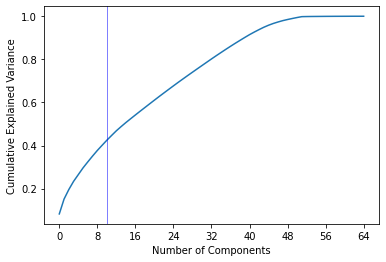

/nfs/home/wze8136/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


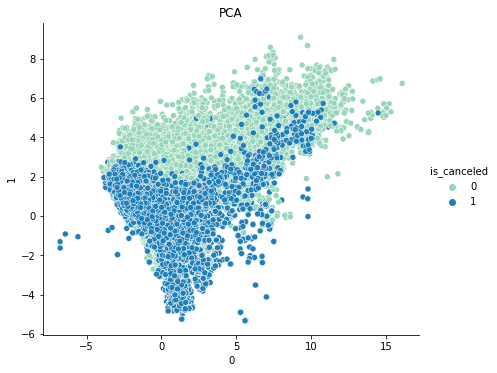

Reconstruction error: 2.726712350115668e-30


In [11]:
# PCA -- plot -> find # of components
ax = plt.figure().gca()
pca = PCA().fit(X_train_resampled_std)

# graph -> Number of Components vs Cumulative Explained Variance
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.axvline(x=10, linewidth=1, color='b', alpha=0.5)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# built PCA with the around 90% CEV
df_pca = PCA(n_components=40).fit_transform(X_train_resampled_std)
df_pca = pd.DataFrame(data = df_pca)
df_pca = pd.concat([df_pca.reset_index().drop(['index'],axis=1),y_train_resampled.reset_index().drop(['index'],axis=1)], axis=1)
df_pca.head()

# graph PCA
sns.pairplot(x_vars=0, y_vars=1, data=df_pca, hue="is_canceled",palette="YlGnBu",size=5,aspect=1.2)
plt.title('PCA')  
plt.show()

# reconstruction error

# Reconstruct data from the reduced representation
X_reconstructed = pca.inverse_transform(pca.transform(X_train_resampled_std))

# Calculate reconstruction error
reconstruction_error = mean_squared_error(X_train_resampled_std, X_reconstructed)

print(f"Reconstruction error: {reconstruction_error}")

## AUTOENCODER

In [12]:
# scale data to auencoder
sData = minmax_scale(X_train_resampled, axis = 0) 
num_principleComponent = 10

In [13]:
# Define the input shape
input_shape = (sData.shape[1],)

# Define the encoding dimension
encoding_dim = num_principleComponent

# Define the input layer
input_data = Input(shape=input_shape)

# Define the encoder layers
encoded = Dense(20, activation='relu')(input_data)
encoded = Dense(10, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Define the decoder layers
decoded = Dense(10, activation='relu')(encoded)
decoded = Dense(20, activation='relu')(decoded)
decoded = Dense(input_shape[0], activation='sigmoid')(decoded)

# Define the autoencoder model
autoencoder = Model(inputs=input_data, outputs=decoded)

# Define the encoder model
encoder = Model(inputs=input_data, outputs=encoded)

# Define the decoder model
encoded_input = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(sData, sData, epochs=50, batch_size=32, shuffle=True)

# Use the encoder to get the reduced dimension representation of the data
encoded_data = pd.DataFrame(encoder.predict(sData))

# Print the shape of the reduced dimension representation
print(encoded_data.shape)

2023-02-21 01:57:21.239379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-21 01:57:21.239407: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-21 01:57:21.239433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (msia-jupyter): /proc/driver/nvidia/version does not exist
2023-02-21 01:57:21.240197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
3759/3759 [==============================] - 5s 992us/step - loss: 0.0393
Epoch 2/50
3759/3759 [==============================] - 4s 992us/step - loss: 0.0248
Epoch 3/50
3759/3759 [==============================] - 4s 966us/step - loss: 0.0212
Epoch 4/50
3759/3759 [==============================] - 4s 1ms/step - loss: 0.0197
Epoch 5/50
3759/3759 [==============================] - 4s 1ms/step - loss: 0.0187
Epoch 6/50
3759/3759 [==============================] - 4s 1ms/step - loss: 0.0178
Epoch 7/50
3759/3759 [==============================] - 4s 1ms/step - loss: 0.0169
Epoch 8/50
3759/3759 [==============================] - 4s 1ms/step - loss: 0.0158
Epoch 9/50
3759/3759 [==============================] - 4s 1ms/step - loss: 0.0147
Epoch 10/50
3759/3759 [==============================] - 4s 1ms/step - loss: 0.0139
Epoch 11/50
3759/3759 [==============================] - 4s 1ms/step - loss: 0.0134
Epoch 12/50
3759/3759 [==============================] - 4s 1ms/step - loss: 0.

In [14]:
#the quality check of dimension reduction 
#A lower reconstruction error indicates a better quality of dimensionality reduction.

# Evaluate the autoencoder on the same data used for training to get the reconstruction error
loss = autoencoder.evaluate(sData, sData)
print("Reconstruction error:", loss)

3759/3759 [==============================] - 3s 749us/step - loss: 0.0095
Reconstruction error: 0.00952318124473095


In [15]:
encoded_data

,0,1,2,3,4,5,6,7,8,9
0,0.0,13.804244,0.0,20.837406,16.967554,8.335273,26.291170,22.839947,12.209212,8.370033
1,0.0,13.439206,0.0,20.580311,5.434938,12.297029,10.221082,16.700218,8.602739,12.845397
2,0.0,6.551372,0.0,10.590496,11.037845,9.992024,20.052122,6.746183,9.856289,7.220889
3,0.0,2.478157,0.0,16.819637,14.093803,10.460170,17.796804,9.988992,8.487242,10.012136
4,0.0,23.744610,0.0,24.607752,5.560188,17.011076,36.883080,19.382793,8.398346,3.136447
...,...,...,...,...,...,...,...,...,...,...
120259,0.0,5.279820,0.0,20.987175,15.911673,10.190458,16.602625,9.605100,5.111334,11.062244
120260,0.0,15.910568,0.0,17.356230,8.330047,18.811359,24.055357,8.122112,7.686635,11.400723
120261,0.0,7.542149,0.0,25.448835,17.838812,7.266345,18.520870,12.033076,7.722907,11.301579
120262,0.0,3.377824,0.0,13.677760,8.541926,15.214671,18.568012,19.670364,10.914252,14.208036


## Visualization (TSNE, UMAP)

## TSNE

/nfs/home/wze8136/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


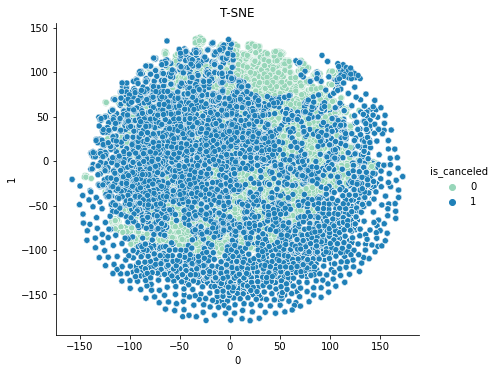

In [16]:
# tsne for visualization with 2d ( could be 3d if needed )
df_tsne = TSNE(n_components=2 , perplexity=20, random_state=0).fit_transform(X_train_resampled_std)
df_tsne = pd.DataFrame(data = df_tsne)
df_tsne = pd.concat([df_tsne.reset_index().drop(['index'],axis=1),y_train_resampled.reset_index().drop(['index'],axis=1)], axis=1)

sns.pairplot(x_vars=0, y_vars=1, data=df_tsne, hue="is_canceled",palette="YlGnBu",size=5,aspect=1.2)
plt.title('T-SNE')
plt.show()

## UMAP

/nfs/home/wze8136/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


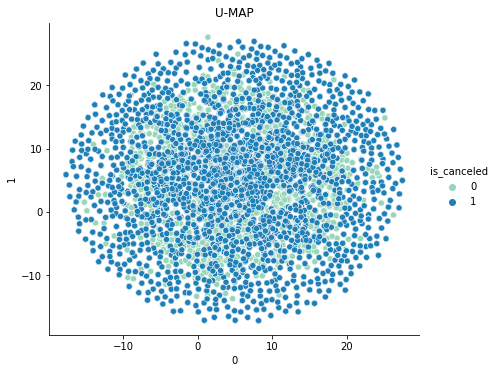

In [17]:
# UMAP for visualization with 2d ( could be 3d if needed )
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0).fit_transform(X_train_resampled_std)
proj_2d = pd.DataFrame(data = umap_2d)
proj_2d = pd.concat([proj_2d.reset_index().drop(['index'],axis=1),y_train_resampled.reset_index().drop(['index'],axis=1)], axis=1)

sns.pairplot(x_vars=0, y_vars=1, data=proj_2d, hue="is_canceled",palette="YlGnBu",size=5,aspect=1.2)
plt.title('U-MAP')
plt.show()